## Common codebase

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import string
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
from gensim.utils import tokenize
from gensim.models import Word2Vec
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn import naive_bayes
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alessio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We started with [this](https://www.kaggle.com/shivamb/go-emotions-google-emotions-dataset) initial dataset, and with the following code we: removed unclear samples, removed duplicated samples, removed useless columns, removed punctuation and computed the ground truths to predict:

In [2]:
DATASET_PATH = "go_emotions_dataset.csv" # original dataset path

def basicprocessing(path):
    df = pd.read_csv(path)
    df.drop_duplicates(subset="text", inplace=True) # remove duplicated comments
    df = df[df["example_very_unclear"] == False].drop(["id","example_very_unclear"], axis="columns") # keep only clear comments and remove unnecessary columns

    punctuation = str.maketrans('', '', string.punctuation) # dict with punctuation to remove (the key is the ASCII code of the char)
    for x,y in zip(range(8216,8232), range(8242,8248)): # adding some other non-conventional unicode punctuation char codes to remove
        punctuation[x] = None
        punctuation[y] = None

    df["text"] = df['text'].str.translate(punctuation) # punctuation removal

    # sentiment index : sentiment group
    sent_dict = {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 2, 7: 2, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 0, 14: 1, 15: 0, 16: 1, 
                17: 0, 18: 0, 19: 1, 20: 0, 21: 0, 22: 2, 23: 0, 24: 1, 25: 1, 26: 2, 27: 2}

    def create_y(row):
        counts = np.zeros(3) # 0 = positive, 1 = negative, 2 = neutral
        indexes = np.where(row == 1)[0]
        for idx in indexes:
            counts[sent_dict[idx]] += 1
        return np.argmax(counts)

    df["y"] = df.iloc[:,1:].apply(lambda x: create_y(x), axis=1) # reduce the y to predict from 28 fine-grained emotions to 3 emotions
    df.drop(df.columns[1:-1], axis="columns", inplace=True)

    return df


def remove_empty(df): # useful function to remove empty rows
    return df[df["text"].str.len() != 0]

df = basicprocessing(DATASET_PATH)
df.head()

,text,y
0,That game hurt,1
2,You do right if you dont care then fuck em,2
3,Man I love reddit,0
4,NAME was nowhere near them he was by the Falcon,2
5,Right Considering its such an important docume...,0


Run the following code if you want to make everything lowercase:

In [126]:
def lowercase(df):
    df['text'] = df['text'].str.lower()

lowercase(df)    
df.head()

,text,y
0,that game hurt,1
2,you do right if you dont care then fuck em,2
3,man i love reddit,0
4,name was nowhere near them he was by the falcon,2
5,right considering its such an important docume...,0


Run the following code if you want to remove stopwords:

In [142]:
stop = stopwords.words('english')

def remove_stopwords(df):
    df['text'] = df['text'].apply(lambda x: ' '.join(word for word in x.split() if word.lower() not in stop)) # removing stopwords

remove_stopwords(df)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alessio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,y
0,game hurt,1
2,right dont care fuck em,2
3,man love reddit,0
4,name nowhere near falcon,2
5,right considering important document know damn...,0


Run the following code if you want to remove less frequent words:

In [195]:
def remove_lessfreq(df):
    word_freq = pd.Series(' '.join(df['text']).split()).value_counts()
    word_freq = word_freq[word_freq > 4]

    def clean_document(document, words):
        return ' '.join([x for x in document.split() if x in words])

    df.text = df.text.apply(lambda d: clean_document(d, set(word_freq.index.values)))
    
    return remove_empty(df)

df = remove_lessfreq(df)
df.head()

,text,y
0,that game hurt,1
2,you do right if you do not care then fuck em,2
3,man I love reddit,0
4,name be nowhere near they he be by the,2
5,right consider its such an important document ...,0


Run the following code if you want to do lemmatization. **NOTE:** Lemmatization always implies lowercasing:

In [194]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def lemmatize(df):
    # function to lemmatize text
    def lemmatization(text):
        lemmas = [token.lemma_ for token in nlp(text)]
        return ' '.join(lemmas)

    df['text'] = df['text'].apply(lambda x: lemmatization(x))

lemmatize(df)
df.head()

,text,y
0,that game hurt,1
2,you do right if you do not care then fuck em,2
3,man I love reddit,0
4,name be nowhere near they he be by the Falcon,2
5,right consider its such an important document ...,0


## Alessandro

## Davide

## Word2Vec

Word embeddings are words mapped to real number vectors such that it can capture the semantic meaning of words. The methods tried previously in this notebook such as BOW and TFIDF do not capture the meaning between the words, they consider the words seperately as features. Word embeddings use some models to map a word into vectors such that similar words will be closer to each other. As shown in the below figure, for example some of the positive words which are adjectives will be closer to each other and vice versa for negative adjectives. It captures semantical and syntactical information of words. To train this model it takes into consideration the words surrounding that word of particular window size. There are different ways of deriving the word embedding vectors. [Word2Vec](https://arxiv.org/abs/1301.3781) is one such method where neural embeddings model is used to learn that. It uses the following two architectures to achieve this:
- CBOW
- Skip Gram

![adjectives](https://miro.medium.com/max/662/1*tL_Oe_33S40oPqVTiR8CLA.png)

**CBOW (Continuous bag of words)**

Here the model predicts the word under consideration given context words within specific window. The hidden layer has the number of dimensions in which the current word needs to be represented at the output layer. Following diagram shows an example with window of size 2 for predicting vector for word "awesome" given the sentence "Restaurant was awesome this time".

![CBOW](https://miro.medium.com/max/700/1*fSg0IJEvDA4iBrLB7C2RpQ.png)

**Skip Gram**

Skip gram is the opposite of CBOW, it predicts embeddings for the surrounding context words in the specific window size given a current word. The input layer contains the current word and the output layer contains the context words. The hidden layer contains the number of dimensions in which we want to represent current word present at the input layer. Following shows an example with window size of 2.

![SG](https://miro.medium.com/max/700/1*MqoUdbWmPM8fQq8jzha-eg.png)

Credits from [here](https://medium.com/swlh/sentiment-classification-using-word-embeddings-word2vec-aedf28fbb8ca)

Let's start by plotting the class distribution of the data, to have a better taste of the dataset:

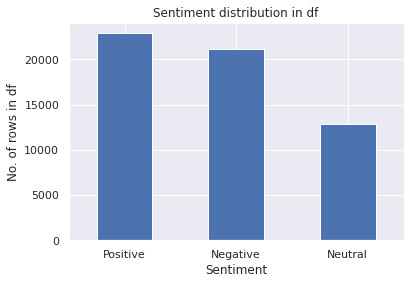

In [145]:
plt.figure()
pd.value_counts(df["y"]).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.xticks([0,1,2], labels=["Positive","Negative","Neutral"], rotation="horizontal")
plt.ylabel("No. of rows in df")
plt.show()

Tokenize the strings and remove empy sentences from dataset:

In [196]:
def tokenization(df): # Tokenize the text column
    df["text"] = df["text"].apply(lambda x: list(tokenize(x, deacc=True)))
    return remove_empty(df)

df = tokenization(df)
df.head()

,text,y
0,"[that, game, hurt]",1
2,"[you, do, right, if, you, do, not, care, then,...",2
3,"[man, I, love, reddit]",0
4,"[name, be, nowhere, near, they, he, be, by, the]",2
5,"[right, consider, its, such, an, important, do...",0


Train the Word2Vec model with our corpus and save it:

In [197]:
def train_w2v(df, vsize, sg):
    return Word2Vec(sentences=df["text"].values, min_count=1, vector_size=vsize, sg=sg) # sg = 0 CBOW model, sg = 1 Skip-gram model

w2v_model = train_w2v(df, 100, 1)

In [199]:
# Unique ID of the word
print("Index of the word 'action':")
print(w2v_model.wv.key_to_index["action"])

# Total number of the words 
print(len(w2v_model.wv))

# Print the size of the word2vec vector for one word
print("Length of the vector generated for a word")
print(len(w2v_model.wv["action"]))

# Get the mean for the vectors for an example comment
print("Print the length after taking average of all word vectors in a sentence:")
print(len(np.mean([w2v_model.wv[token] for token in df["text"].iloc[0]], axis=0)))

Index of the word 'action':
853
6238
Length of the vector generated for a word
100
Print the length after taking average of all word vectors in a sentence:
100


Obtain the embedding for every sentence in our dataset:

In [5]:
# Store the vectors for dataset in following file, stores one row at a time to avoid memory overload due to big dataframe loading
def save_dataset(filename, w2v_model):
    with open(filename, 'w+') as word2vec_file:
        header = ",".join([str(i) for i in range(len(w2v_model.wv["action"]))])
        word2vec_file.write(header+",y")
        word2vec_file.write('\n')
        for sentence,ground in zip(df["text"],df["y"]):
            model_vector = (np.mean([w2v_model.wv[token] for token in sentence], axis=0)).tolist()
            line = ",".join([str(vector_element) for vector_element in model_vector])
            word2vec_file.write(line+","+str(ground))
            word2vec_file.write('\n')

In [1]:
word2vec_filename = 'w2v1000SG/dataset_w2v1000_nofreq_lemmatiz.csv'
#save_dataset(word2vec_filename, w2v_model)

Load the data and obtain train and test sets:

In [3]:
# Train Test Split Function
def split_data(X,y):
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Load from the filename
data = pd.read_csv(word2vec_filename)
X_train, X_test, y_train, y_test = split_data(data.iloc[:,:-1], data["y"])
X_train.shape, y_train.shape

((45405, 1000), (45405,))

### Logistic Regression

First we perform hyperparameter tuning with cross validation in order to evaluate the best model:

In [166]:
#Hyperparameter tuning and 5-fold cross validation in order to evaluate the best model
lr = GridSearchCV(LogisticRegression(multi_class="multinomial"), {
    "penalty" : ["l2", "none"],
    "max_iter" : [500, 1000, 2000]
}, cv=5, return_train_score=False)

start_time = time.time()
#Fit the model
lr.fit(X_train, y_train)
print("Time taken to find the best LR model with word2vec vectors: " + str(time.time() - start_time))
pd.DataFrame(lr.cv_results_)[["params","mean_test_score"]]

Time taken to find the best LR model with word2vec vectors: 590.2385878562927


,params,mean_test_score
0,"{'max_iter': 500, 'penalty': 'l2'}",0.536543
1,"{'max_iter': 500, 'penalty': 'none'}",0.541487
2,"{'max_iter': 1000, 'penalty': 'l2'}",0.536214
3,"{'max_iter': 1000, 'penalty': 'none'}",0.543157
4,"{'max_iter': 2000, 'penalty': 'l2'}",0.536214
5,"{'max_iter': 2000, 'penalty': 'none'}",0.544278


Then we use the best model:

In [172]:
#Istantiate the best model
best_lr = LogisticRegression(multi_class="multinomial", **lr.best_params_)

start_time = time.time()
#Fit the model
best_lr.fit(X_train, y_train)
print("Time taken to fit the LR model with word2vec vectors: " + str(time.time() - start_time))

def testModel(X,y,model):
    y_hat = model.predict(X)
    print(classification_report(y, y_hat))
    cmat = confusion_matrix(y, y_hat, normalize="true")
    ax= plt.subplot()
    sns.heatmap(cmat, annot=True, ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')

For Word2Vec model's features with vector_size=100, CBOW architecture and using Logistic Regression, we obtained the best accuracy **(0.55)** with many preprocessing combinations: lemmatization, lemmatization and removed low frequency words, lowercase and removed low frequency words, lowercase no stopwords and removed low frequency words. For shortening the notebook here we just report the results of one we have chosen to keep, but all the experiments are reproducible as we attach the already embedded datasets in w2v100CBOW folder. We have chosen to keep here the results with lowercase dataset, removed low frequency words and also stopwords removed, because is the dataset which produces the more lightweight corpus (so the less number of different words) to train the Word2Vec model on.

              precision    recall  f1-score   support

           0       0.65      0.62      0.64      4566
           1       0.48      0.18      0.26      2564
           2       0.49      0.70      0.57      4169

    accuracy                           0.55     11299
   macro avg       0.54      0.50      0.49     11299
weighted avg       0.55      0.55      0.53     11299



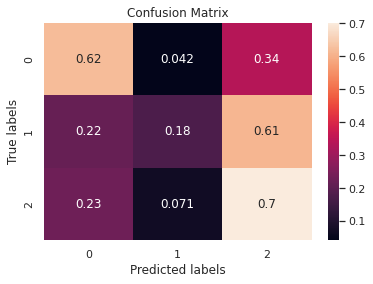

In [118]:
testModel(X_test, y_test, best_lr) #test w\ Word2Vec model with vector_size=100, lowercase, no low frequency words and no stopwords (punctuation is always removed)

For Word2Vec model's features with vector_size=1000, CBOW architecture and using Logistic Regression, we obtained the best accuracy **(0.57)** with many preprocessing combinations: lowercase and no stopwords, lowercase no stopwords and lemmatization, lowercase no stopwords and removed low frequency words, lowercase and removed low frequency words, lowercase removed low frequency words and lemmatization. For shortening the notebook here we just report the results of one we have chosen to keep, but all the experiments are reproducible as we attach the already embedded datasets in w2v1000CBOW folder. We have chosen to keep here the results with lowercase dataset, removed low frequency words and applied lemmatization, because is the dataset which produces the more lightweight corpus (so the less number of different words) to train the Word2Vec model on. So with a feature vector size of 10x the default we get an increase of 0.02 in accuracy.

              precision    recall  f1-score   support

           0       0.66      0.66      0.66      4575
           1       0.52      0.22      0.31      2570
           2       0.51      0.69      0.59      4207

    accuracy                           0.57     11352
   macro avg       0.56      0.52      0.52     11352
weighted avg       0.57      0.57      0.55     11352



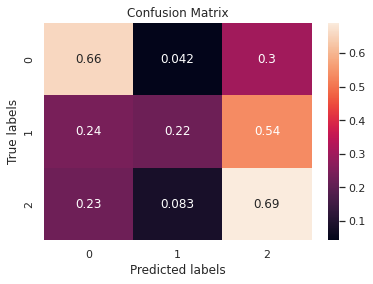

In [159]:
testModel(X_test, y_test, best_lr) # test with Word2Vec model with vector_size=1000, lowercase, removed low frequencies and lemmatization

For Word2Vec model's features with vector_size=100, SG architecture and using Logistic Regression, we obtained the best accuracy **(0.57)** with many preprocessing combinations: only lemmatization, lowercase removed low frequency words and lemmatization, lowercase no stopwords and lemmatization, lowercase and removed low frequency words. For shortening the notebook here we just report the results of one we have chosen to keep, but all the experiments are reproducible as we attach the already embedded datasets in w2v100SG folder. We have chosen to keep here the results with lowercase dataset, removed low frequency words and lemmatization, because is the dataset which produces the more lightweight corpus (so the less number of different words) to train the Word2Vec model on.

              precision    recall  f1-score   support

           0       0.64      0.67      0.65      4575
           1       0.51      0.22      0.31      2570
           2       0.51      0.67      0.58      4207

    accuracy                           0.57     11352
   macro avg       0.56      0.52      0.51     11352
weighted avg       0.56      0.57      0.55     11352



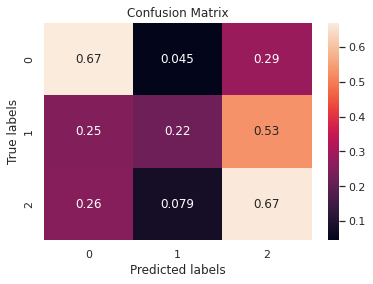

In [150]:
testModel(X_test, y_test, best_lr) # test with Word2Vec model with vector_size=100, lowercase, removed low frequencies and lemmatization

For Word2Vec model's features with vector_size=1000, SG architecture and using Logistic Regression, we obtained the best accuracy **(0.60)** with many preprocessing combinations: lowercase removed low frequency words and lemmatization, lowercase no stopwords and lemmatization, lowercase and removed low frequency words. For shortening the notebook here we just report the results of one we have chosen to keep, but all the experiments are reproducible as we attach the already embedded datasets in w2v1000SG folder. We have chosen to keep here the results with lowercase dataset, removed low frequency words and lemmatization, because is the dataset which produces the more lightweight corpus (so the less number of different words) to train the Word2Vec model on. **This model turns out to be the best for Logistic Regression, and Logistic Regression turns out to be a better algorithm than Naive Bayes for this task and with this feature modeling.** Here we also notice that increasing the size of the vector of 10 times produced a good improvement, especially in the negative sentiment class. That's probably due to the fact that the Word2Vec model can separate better between 3 classes if the feature vectors are bigger.

              precision    recall  f1-score   support

           0       0.69      0.68      0.68      4575
           1       0.57      0.31      0.40      2570
           2       0.53      0.69      0.60      4207

    accuracy                           0.60     11352
   macro avg       0.60      0.56      0.56     11352
weighted avg       0.60      0.60      0.59     11352



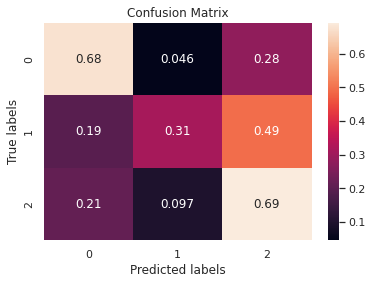

In [155]:
testModel(X_test, y_test, best_lr) # test with Word2Vec model with vector_size=1000, lowercase, removed low frequencies and lemmatization

The following is the code used for testing Logistic Regression models:

In [168]:
cbow100 = {}
cbow1000 = {}
sg100 = {}
sg1000 = {}

for architecture in [0,1]:
    for vecsize in [100,1000]:
        for preprocessing in ["lcase_nofreq","lcase_nostop_lemmatiz","lcase_nostop_nofreq","lcase_nostop","lcase","lemmatiz","nofreq_lemmatiz","nofreq","original"]:
            df = basicprocessing(DATASET_PATH)
            
            if "lcase" in preprocessing:
                lowercase(df)
            if "nostop" in preprocessing:
                remove_stopwords(df)
            if "lemmatiz" in preprocessing:
                lemmatize(df)
            if "nofreq" in preprocessing:
                df = remove_lessfreq(df)
            
            df = tokenization(df)
            w2v_model = train_w2v(df,vecsize,architecture)
            
            if architecture == 0:
                filename = "w2v"+str(vecsize)+"CBOW/dataset_w2v"+str(vecsize)+"_"+preprocessing+".csv"
            else:
                filename = "w2v"+str(vecsize)+"SG/dataset_w2v"+str(vecsize)+"_"+preprocessing+".csv"
                
            save_dataset(filename, w2v_model)

            data = pd.read_csv(filename)
            X_train, X_test, y_train, y_test = split_data(data.iloc[:,:-1], data["y"])

            #Istantiate the best model
            best_lr = LogisticRegression(multi_class="multinomial", **lr.best_params_)
            #Fit the model
            best_lr.fit(X_train, y_train)

            y_hat = best_lr.predict(X_test)
            if vecsize == 100:
                if architecture == 0: cbow100[preprocessing] = accuracy_score(y_test, y_hat)
                else: sg100[preprocessing] = accuracy_score(y_test, y_hat)
            else:
                if architecture == 0: cbow1000[preprocessing] = accuracy_score(y_test, y_hat)
                else: sg1000[preprocessing] = accuracy_score(y_test, y_hat)  

print("cbow"+str(100))
print(cbow100)
print()
print("cbow"+str(1000))
print(cbow1000)
print()
print("sg"+str(100))
print(sg100)
print()
print("sg"+str(1000))
print(sg1000)

cbow100
{'lcase_nofreq': 0.545910731578484, 'lcase_nostop_lemmatiz': 0.5569742867206763, 'lcase_nostop_nofreq': 0.5494291530223914, 'lcase_nostop': 0.558295174357168, 'lcase': 0.5446475654772368, 'lemmatiz': 0.5518544559676569, 'nofreq_lemmatiz': 0.5484496124031008, 'nofreq': 0.5312472454825915, 'original': 0.5349797855510634}

cbow1000
{'lcase_nofreq': 0.5724095430935822, 'lcase_nostop_lemmatiz': 0.5693025713279324, 'lcase_nostop_nofreq': 0.5725285423488804, 'lcase_nostop': 0.5664846777034167, 'lcase': 0.5639831253295834, 'lemmatiz': 0.5636315696959043, 'nofreq_lemmatiz': 0.5707364341085271, 'nofreq': 0.5553107095636844, 'original': 0.5443838987519775}

sg100
{'lcase_nofreq': 0.5654547055198521, 'lcase_nostop_lemmatiz': 0.5699189855582951, 'lcase_nostop_nofreq': 0.5601380653155147, 'lcase_nostop': 0.5639309616061994, 'lcase': 0.5591492353664967, 'lemmatiz': 0.56521357004746, 'nofreq_lemmatiz': 0.5665081042988019, 'nofreq': 0.5546055531070956, 'original': 0.5588855686412375}

sg1000
{'

### Naive Bayes
MultinomialNB assumes that features have multinomial distribution which is a generalization of the binomial distribution. Neither binomial nor multinomial distributions can contain negative values. Also, MultinomialNB is designed for classification with discrete features, meanwhile with word embeddings we have continuous features. That's why here we will use GaussianNB. Since this algorithm doesn't have any relevant hyperparameter to tune, we just proceed by training and testing our model:

In [190]:
#Istantiate the best model
nb = naive_bayes.GaussianNB()

start_time = time.time()
#Fit the model
nb.fit(X_train, y_train)
print("Time taken to fit the NB model with word2vec vectors: " + str(time.time() - start_time))

Time taken to fit the NB model with word2vec vectors: 0.41783857345581055


For Word2Vec model's features with vector_size=100, CBOW architecture and using Naive Bayes, we obtained the best accuracy **(0.44)** with lowercasing the dataset, removing stopwords and doing lemmatization. For shortening the notebook here we just report the results of this experiment, but all the experiments are reproducible as we attach the already embedded datasets in w2v100CBOW folder. **Naive Bayes, in general, turns out to be a worse method than Logistic Regression for this task and with Word2Vec's feature modeling. That's probably due to the fact that Naive Bayes takes the assumption of the independence of the features, meanwhile in the sentiment analysis task of course that's not true, since the sentence has related words in it.**

              precision    recall  f1-score   support

           0       0.57      0.48      0.52      4576
           1       0.29      0.45      0.35      2570
           2       0.46      0.39      0.42      4210

    accuracy                           0.44     11356
   macro avg       0.44      0.44      0.43     11356
weighted avg       0.47      0.44      0.45     11356



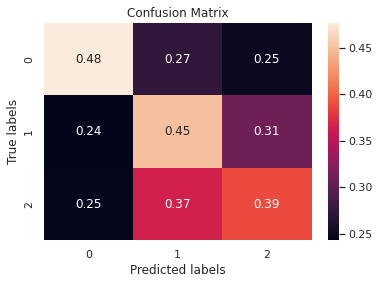

In [178]:
testModel(X_test, y_test, nb)

For Word2Vec model's features with vector_size=1000, CBOW architecture and using Naive Bayes, we obtained the best accuracy **(0.44)** with lowercasing the dataset, removing stopwords and doing lemmatization. For shortening the notebook here we just report the results of this experiment, but all the experiments are reproducible as we attach the already embedded datasets in w2v1000CBOW folder. Here we notice that increasing the size of the vector of 10 times didn't produce any improvement at all.

              precision    recall  f1-score   support

           0       0.55      0.51      0.53      4576
           1       0.29      0.44      0.35      2570
           2       0.46      0.36      0.41      4210

    accuracy                           0.44     11356
   macro avg       0.44      0.44      0.43     11356
weighted avg       0.46      0.44      0.44     11356



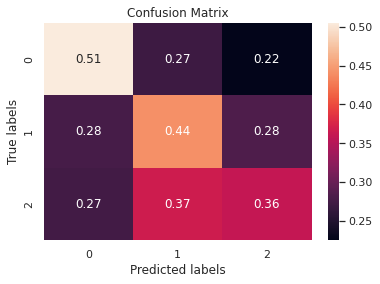

In [182]:
testModel(X_test, y_test, nb)

For Word2Vec model's features with vector_size=100, SG architecture and using Naive Bayes, we obtained the best accuracy **(0.45)** with both: only removing low frequency words; lowercase, removed stopwords and removed low frequency words. For shortening the notebook here we just report the results of the latter, but all the experiments are reproducible as we attach the already embedded datasets in w2v100SG folder. We have chosen to keep here the results with lowercase dataset, removed low frequency words and removed stopwords, because is the dataset which produces the more lightweight corpus (so the less number of different words) to train the Word2Vec model on.

              precision    recall  f1-score   support

           0       0.61      0.41      0.49      4566
           1       0.32      0.51      0.39      2564
           2       0.46      0.45      0.45      4169

    accuracy                           0.45     11299
   macro avg       0.46      0.46      0.45     11299
weighted avg       0.49      0.45      0.46     11299



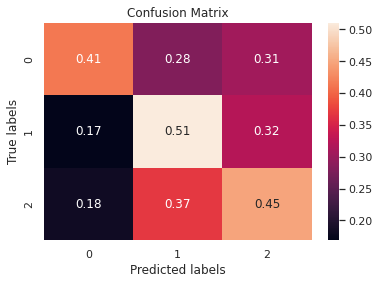

In [186]:
testModel(X_test, y_test, nb)

For Word2Vec model's features with vector_size=1000, SG architecture and using Naive Bayes, we obtained the best accuracy **(0.44)** with: only removing low frequency words; lowercase, removed stopwords and lemmatization; lowercase and removed stopwords; lowercase, removed low frequency words and removed stopwords. For shortening the notebook here we just report the results of the latter, but all the experiments are reproducible as we attach the already embedded datasets in w2v1000SG folder. We have chosen to keep here the results with lowercase dataset, removed low frequency words and removed stopwords because is the dataset which produces the more lightweight corpus (so the less number of different words) to train the Word2Vec model on. Here we notice again that increasing the size of the vector of 10 times didn't produce any improvement at all.

              precision    recall  f1-score   support

           0       0.62      0.42      0.50      4566
           1       0.30      0.58      0.40      2564
           2       0.47      0.37      0.41      4169

    accuracy                           0.44     11299
   macro avg       0.46      0.46      0.44     11299
weighted avg       0.49      0.44      0.45     11299



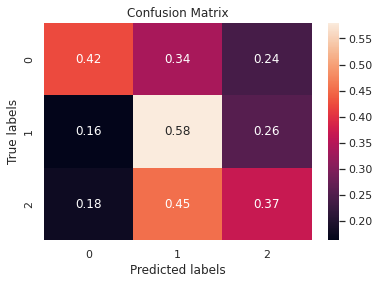

In [191]:
testModel(X_test, y_test, nb)

In [171]:
cbow100 = {}
cbow1000 = {}
sg100 = {}
sg1000 = {}

for architecture in [0,1]:
    for vecsize in [100,1000]:
        for preprocessing in ["lcase_nofreq","lcase_nostop_lemmatiz","lcase_nostop_nofreq","lcase_nostop","lcase","lemmatiz","nofreq_lemmatiz","nofreq","original"]:
            
            if architecture == 0:
                filename = "w2v"+str(vecsize)+"CBOW/dataset_w2v"+str(vecsize)+"_"+preprocessing+".csv"
            else:
                filename = "w2v"+str(vecsize)+"SG/dataset_w2v"+str(vecsize)+"_"+preprocessing+".csv"

            data = pd.read_csv(filename)
            X_train, X_test, y_train, y_test = split_data(data.iloc[:,:-1], data["y"])

            #Istantiate the best model
            nb = naive_bayes.GaussianNB()
            #Fit the model
            nb.fit(X_train, y_train)

            y_hat = nb.predict(X_test)
            if vecsize == 100:
                if architecture == 0: cbow100[preprocessing] = accuracy_score(y_test, y_hat)
                else: sg100[preprocessing] = accuracy_score(y_test, y_hat)
            else:
                if architecture == 0: cbow1000[preprocessing] = accuracy_score(y_test, y_hat)
                else: sg1000[preprocessing] = accuracy_score(y_test, y_hat)  

print("cbow"+str(100))
print(cbow100)
print()
print("cbow"+str(1000))
print(cbow1000)
print()
print("sg"+str(100))
print(sg100)
print()
print("sg"+str(1000))
print(sg1000)

cbow100
{'lcase_nofreq': 0.4234527687296417, 'lcase_nostop_lemmatiz': 0.43791828108488906, 'lcase_nostop_nofreq': 0.4210992123196743, 'lcase_nostop': 0.42488552307150407, 'lcase': 0.42828265072947796, 'lemmatiz': 0.41993320442960097, 'nofreq_lemmatiz': 0.41331923890063427, 'nofreq': 0.43032172763331866, 'original': 0.42828265072947796}

cbow1000
{'lcase_nofreq': 0.414473105026851, 'lcase_nostop_lemmatiz': 0.4366854526241634, 'lcase_nostop_nofreq': 0.41437295335870433, 'lcase_nostop': 0.4205706234589644, 'lcase': 0.4186148708033046, 'lemmatiz': 0.41149586922130427, 'nofreq_lemmatiz': 0.41014799154334036, 'nofreq': 0.41851035698545613, 'original': 0.4190543153454034}

sg100
{'lcase_nofreq': 0.43340082753763537, 'lcase_nostop_lemmatiz': 0.44029587883057414, 'lcase_nostop_nofreq': 0.4487122754226038, 'lcase_nostop': 0.44135258893976753, 'lcase': 0.4285463174547372, 'lemmatiz': 0.4110564246792055, 'nofreq_lemmatiz': 0.42177589852008457, 'nofreq': 0.4501542529748788, 'original': 0.4387414308

### Feature analysis

One thing to notice is that the total input dimension in Word2Vec respect to BOW and TF-IDF has reduced from vocab size to 100 or 1000 (hyperparameter). That is here the dimension can be made custom, but as it is capturing the necessary things and only limited things to describe the words it is a good compromise between accuracy and computational complexity for the classification model. From now we only consider the best model for feature analysis, which is the one with 60% accuracy.

**Principal component analysis**: it doesn't tell us anything interesting except the fact that the dataset is really hard to embed, and therefore also to predict.

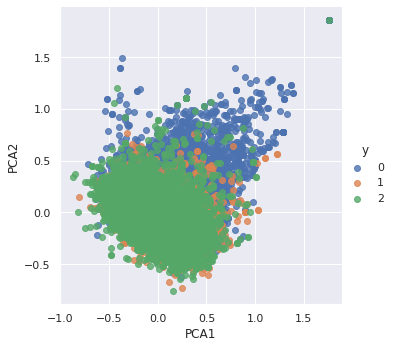

In [ ]:
model = PCA(n_components=2)
model.fit(X_train)
X_2D = pd.DataFrame(model.transform(X_train), columns=["PCA1", "PCA2"])
X_2D = X_2D.assign(y=pd.Series(y_train).values) # in order to reset index
sns.lmplot(x="PCA1", y="PCA2", hue="y", data=X_2D, fit_reg=False);

**Correlation matrix:** we can see that some of the features are correlated.

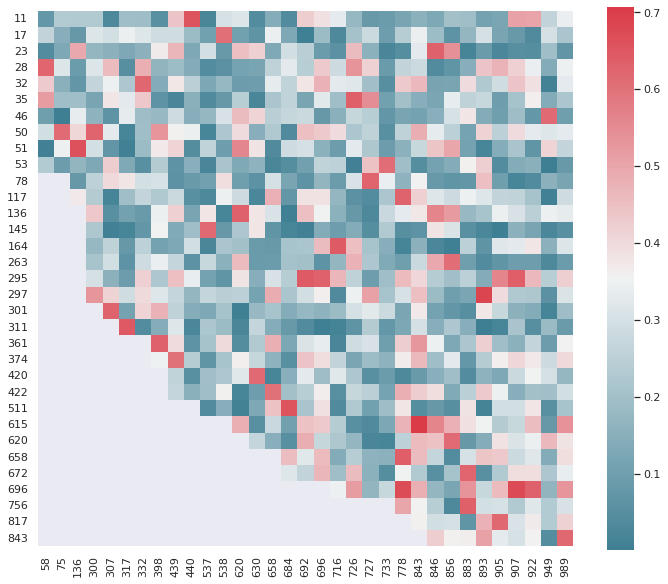

In [41]:
corr_mat = data.iloc[:,:-1].corr().abs()
upper_tri = corr_mat.where(np.triu(np.ones(corr_mat.shape),k=1).astype(np.bool))
upper_tri = upper_tri[(upper_tri >= 0.6).any(axis=1)]
upper_tri = upper_tri.loc[:,(upper_tri >= 0.6).any(axis=0)]

_, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(upper_tri, cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax);

Here we give a try to modeling polynomial features and performing polynomial logistic regression. Other than the fact that it takes much more time to train, it doesn't take us any improvement, instead we dropped from 0.57 to 0.55 accuracy (it was performed on the best dataset generated by the Word2Vec model with vector_size=100 and SG architecture, due to computational complexity issues).

In [51]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)

clf = LogisticRegression(multi_class="multinomial", max_iter=2000, penalty="none")
clf.fit(X_train, y_train)
print(accuracy_score(y_test, clf.predict(X_test)))

0.5556730091613813
